<a href="https://colab.research.google.com/github/Asad808/Deep-Convolutional-Generative-Adversarial-Network-DCGAN-using-PyTorch/blob/main/Generative_Adversarial_Network_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Network Using FashionMNIST with PyTorch

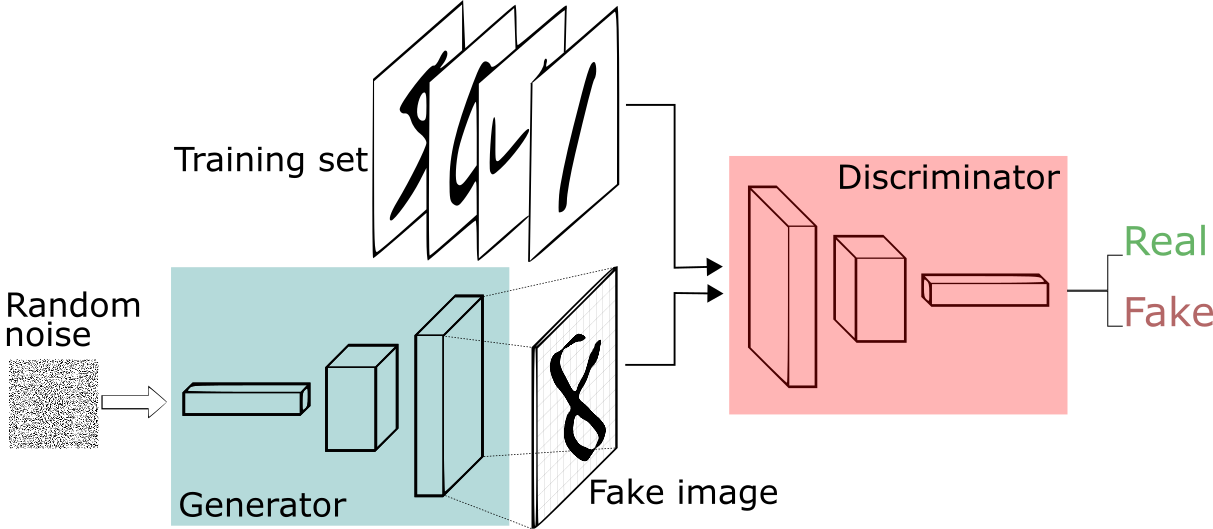

In [66]:
import torch 
torch.manual_seed(42)
import numpy as np 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm

# Configurations

In [67]:
device = "cuda"

batch_size = 128

noise_dim = 64

# Optimizer Parameters

lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

# Training Variables

epochs = 50

# Load MNIST Dataset 

In [68]:
from torchvision import datasets, transforms as T

In [69]:
train_augs = T.Compose([
    T.RandomRotation((-20, +20)),
    T.ToTensor()
])

In [70]:
trainset = datasets.FashionMNIST("FashionMNIST/", download = True, train = True, transform = train_augs)

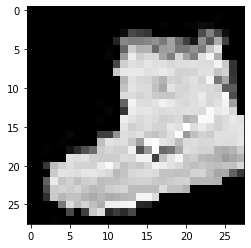

In [71]:
image, label = trainset[0]

plt.imshow(image.squeeze(), cmap = "gray")

# Load Dataset Into Batches 

In [72]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [73]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)

In [74]:
print("total number of batches: ", len(trainloader))

total number of batches:  469


In [75]:
dataiter = iter(trainloader)
images, _ = next(dataiter)
print(_)

tensor([7, 1, 1, 8, 9, 7, 0, 4, 2, 6, 4, 7, 8, 1, 5, 5, 0, 1, 8, 2, 3, 1, 6, 0,
        2, 3, 1, 7, 7, 5, 4, 8, 1, 7, 1, 7, 3, 8, 7, 2, 1, 4, 7, 7, 5, 9, 5, 7,
        3, 5, 9, 7, 1, 3, 3, 7, 0, 8, 3, 5, 1, 4, 9, 2, 0, 4, 5, 8, 3, 0, 4, 3,
        5, 2, 2, 3, 9, 1, 0, 9, 6, 7, 5, 3, 0, 0, 7, 1, 4, 5, 7, 7, 3, 0, 0, 6,
        1, 9, 0, 6, 3, 6, 7, 8, 9, 7, 0, 7, 8, 4, 1, 7, 3, 1, 7, 2, 0, 6, 0, 1,
        0, 1, 8, 2, 7, 2, 5, 8])


In [76]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

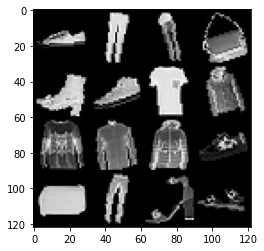

In [77]:
show_tensor_images(images, num_images = 16)

# Create Discriminator Network 

In [78]:
#In case if torch summary is not installed 

!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [79]:
from torch import nn
from torchsummary import summary 

In [80]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [81]:
from torch.nn.modules.batchnorm import BatchNorm2d
def get_disc_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [82]:
from torch.nn.modules.flatten import Flatten
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()

    self.block1 = get_disc_block(1, 16, (3,3), 2)
    self.block2 = get_disc_block(16, 32, (5,5), 2)
    self.block3 = get_disc_block(32, 64, (5,5), 2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features = 64, out_features=1)

  def forward(self, images):
    
    x1 = self.block1(images)
    x2 = self.block2(x1)
    x3 = self.block3(x2)
    
    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5




In [83]:
D = Discriminator()
D.to(device)

summary(D, input_size = (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network 

In [84]:
'''

Network : Generator 

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) 
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator \n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) \n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                               

In [85]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False):
  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh()
    )

  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
    )

In [86]:
class Generator(nn.Module):
  def __init__(self, noise_dim):
    super(Generator, self).__init__()

    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
    self.block_2 = get_gen_block(256, 128, (4,4), 1)
    self.block_3 = get_gen_block(128, 64, (3,3), 2)
    
    self.block_4 = get_gen_block(64, 1, (4,4), 2, final_block = True)

  def forward(self, r_noise_vec):

    x = r_noise_vec.view(-1, self.noise_dim, 1, 1)

    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)

    return x4


In [87]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size = (1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [88]:
# Replace Random initialized weights to Normal weights  

def weights_init(m):  
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [89]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [90]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss


In [91]:
D_opt = torch.optim.Adam(D.parameters() ,lr = lr, betas = (beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters() ,lr = lr, betas = (beta_1, beta_2))

# Training Loop 

Epoch : 1 | D_loss : 0.6837640463162079 | G_loss : 0.6924536237076148


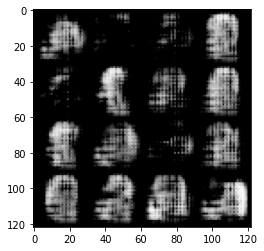

Epoch : 2 | D_loss : 0.6692080745564849 | G_loss : 0.7260154359884607


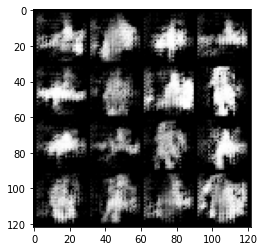

Epoch : 3 | D_loss : 0.6392026929967185 | G_loss : 0.7706584704201868


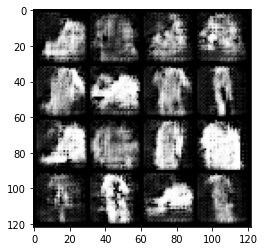

Epoch : 4 | D_loss : 0.6084222563548383 | G_loss : 0.8202980198839834


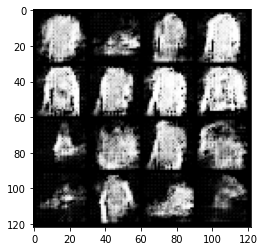

Epoch : 5 | D_loss : 0.590268528918976 | G_loss : 0.8523589835238101


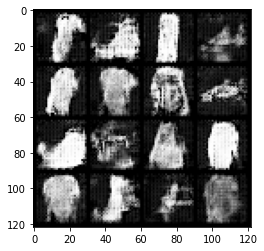

Epoch : 6 | D_loss : 0.581509549099245 | G_loss : 0.8749664264447146


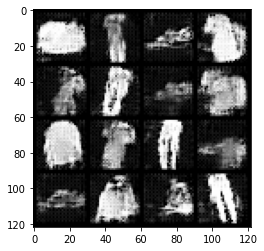

Epoch : 7 | D_loss : 0.5806029015766786 | G_loss : 0.8824625542677288


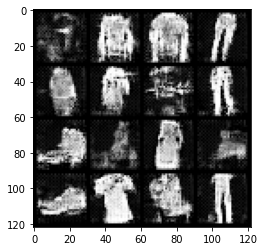

Epoch : 8 | D_loss : 0.5840603020399618 | G_loss : 0.8861194275843818


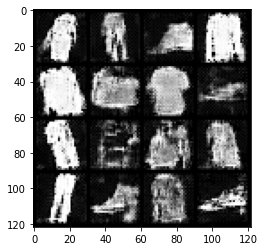

Epoch : 9 | D_loss : 0.5869874300987228 | G_loss : 0.8832197559159448


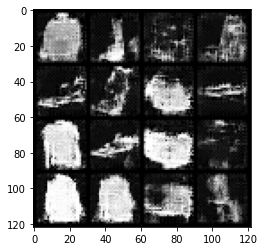

Epoch : 10 | D_loss : 0.5926869600566466 | G_loss : 0.8851297568919053


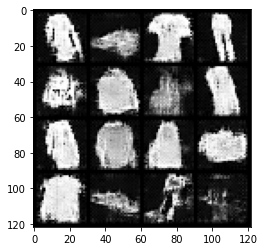

Epoch : 11 | D_loss : 0.5970231740713627 | G_loss : 0.8837847921894049


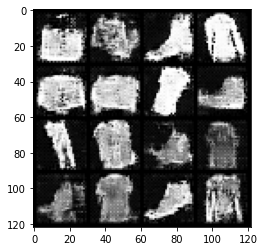

Epoch : 12 | D_loss : 0.6001574527988556 | G_loss : 0.8817037247391398


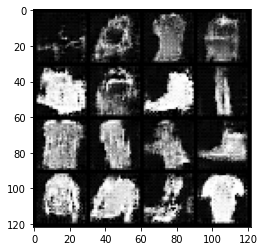

Epoch : 13 | D_loss : 0.605652771016428 | G_loss : 0.8784782685069387


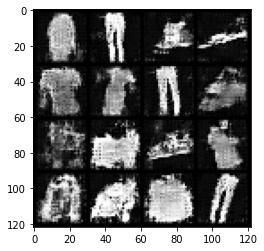

Epoch : 14 | D_loss : 0.607520261298873 | G_loss : 0.8793985007414177


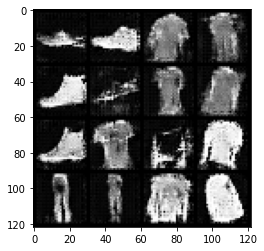

Epoch : 15 | D_loss : 0.6095039866118035 | G_loss : 0.878986343900278


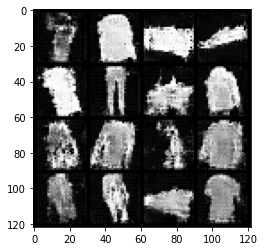

Epoch : 16 | D_loss : 0.6111631944997987 | G_loss : 0.8783239273628446


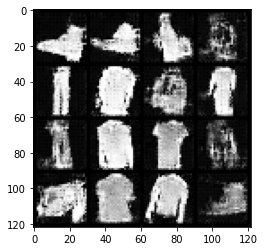

Epoch : 17 | D_loss : 0.6142809274100037 | G_loss : 0.8777651725801577


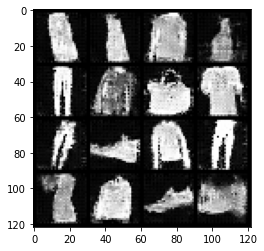

Epoch : 18 | D_loss : 0.6145942516164231 | G_loss : 0.8739143832406001


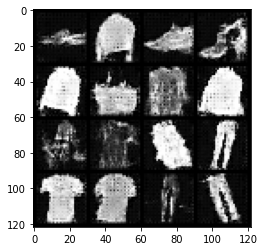

Epoch : 19 | D_loss : 0.6136254034062693 | G_loss : 0.8738092470016561


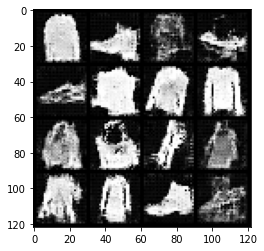

Epoch : 20 | D_loss : 0.6155839032455802 | G_loss : 0.8786728450738545


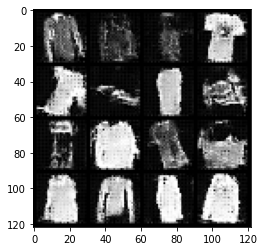

Epoch : 21 | D_loss : 0.6165572856026672 | G_loss : 0.8771415310882048


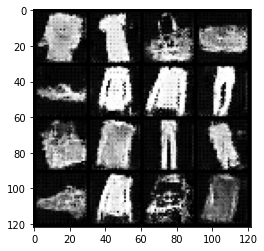

Epoch : 22 | D_loss : 0.6156245725495475 | G_loss : 0.882843218251332


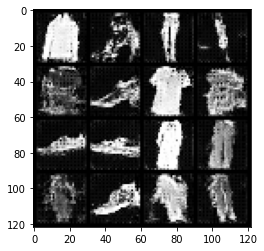

Epoch : 23 | D_loss : 0.6165814347612832 | G_loss : 0.8862657258505506


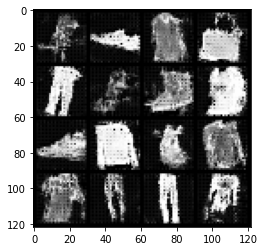

Epoch : 24 | D_loss : 0.6163838111769671 | G_loss : 0.88315785337867


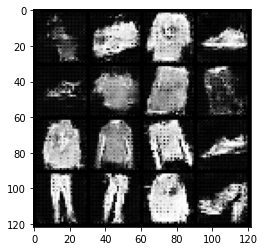

Epoch : 25 | D_loss : 0.6165907315608027 | G_loss : 0.8848759010910734


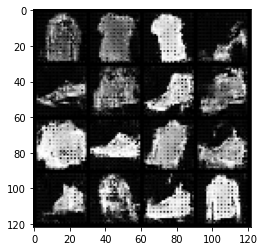

Epoch : 26 | D_loss : 0.6132085831688919 | G_loss : 0.8944853170594173


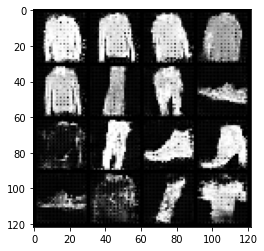

Epoch : 27 | D_loss : 0.6114427799354992 | G_loss : 0.8953291804297392


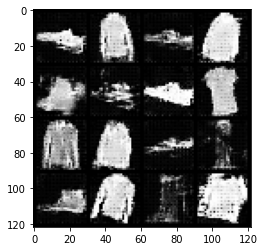

Epoch : 28 | D_loss : 0.6115467498805731 | G_loss : 0.9023498018413211


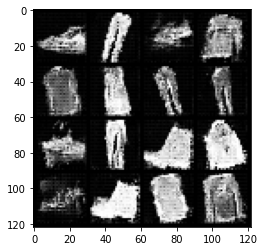

Epoch : 29 | D_loss : 0.6119042598108239 | G_loss : 0.8998184694664311


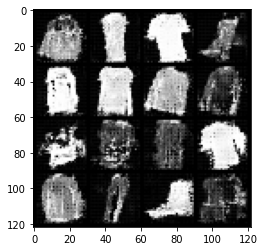

Epoch : 30 | D_loss : 0.6115497922592326 | G_loss : 0.9057187364299668


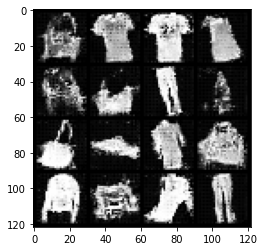

Epoch : 31 | D_loss : 0.6123975104868793 | G_loss : 0.9065158237526412


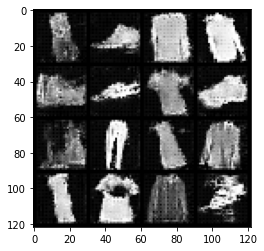

Epoch : 32 | D_loss : 0.607694129191482 | G_loss : 0.9151510559419579


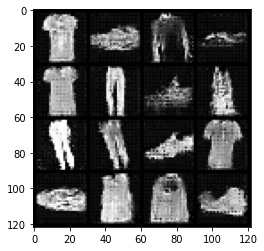

Epoch : 33 | D_loss : 0.6068530008991135 | G_loss : 0.9133864819113888


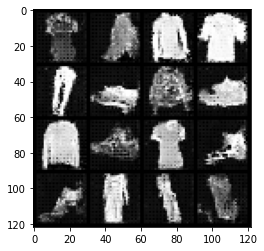

Epoch : 34 | D_loss : 0.6054298571432069 | G_loss : 0.9206988380661906


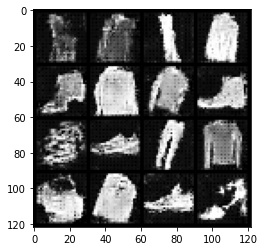

Epoch : 35 | D_loss : 0.6030560547609065 | G_loss : 0.9277016825513291


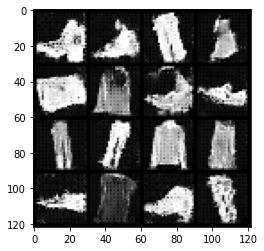

Epoch : 36 | D_loss : 0.6015797301904479 | G_loss : 0.928682512947237


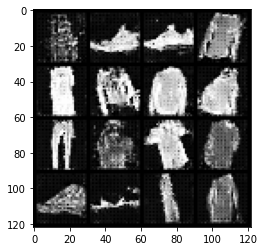

Epoch : 37 | D_loss : 0.6008883557085798 | G_loss : 0.9381375727114647


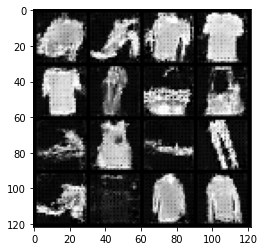

Epoch : 38 | D_loss : 0.6002628597369326 | G_loss : 0.9359863892292926


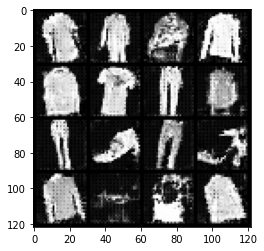

Epoch : 39 | D_loss : 0.5966375870491142 | G_loss : 0.9466428784673402


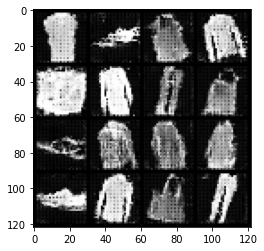

Epoch : 40 | D_loss : 0.5923952321762215 | G_loss : 0.9561490110242798


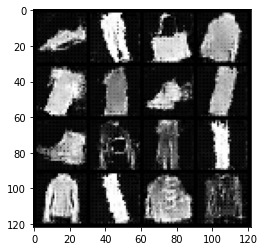

Epoch : 41 | D_loss : 0.5913215284662714 | G_loss : 0.9613041842161719


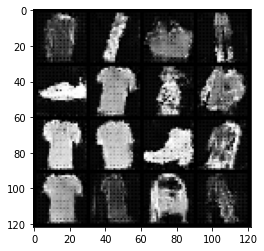

Epoch : 42 | D_loss : 0.5860299842952411 | G_loss : 0.9711928166814451


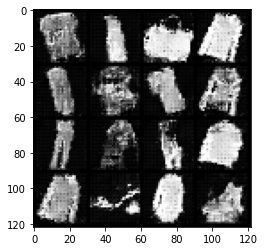

Epoch : 43 | D_loss : 0.5846817821327811 | G_loss : 0.9837187487941815


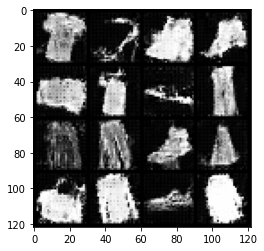

Epoch : 44 | D_loss : 0.5821933249420703 | G_loss : 0.9858493666404854


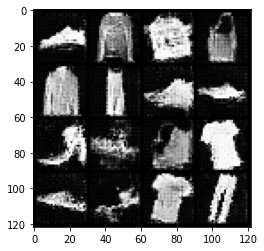

Epoch : 45 | D_loss : 0.5820932399743656 | G_loss : 0.9889426331784426


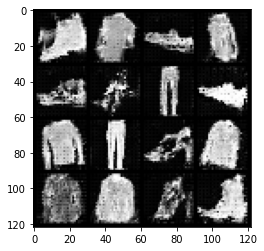

Epoch : 46 | D_loss : 0.5822741124929904 | G_loss : 0.9970307243404104


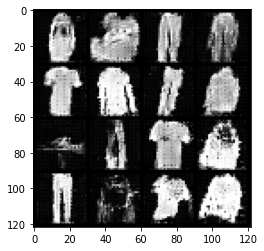

Epoch : 47 | D_loss : 0.5800386728254209 | G_loss : 1.0001088627365862


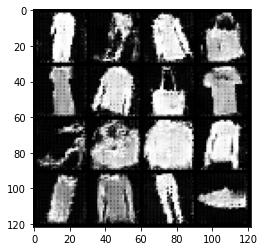

Epoch : 48 | D_loss : 0.5810331098560585 | G_loss : 0.9942885107323051


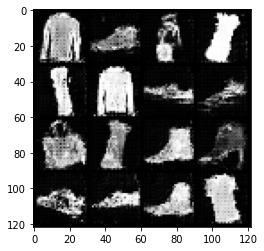

Epoch : 49 | D_loss : 0.5807180743990168 | G_loss : 1.0031567221003046


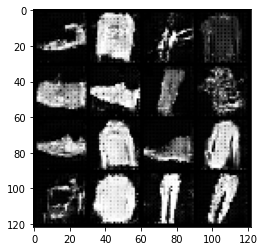

Epoch : 50 | D_loss : 0.583175119941931 | G_loss : 0.9983457104483647


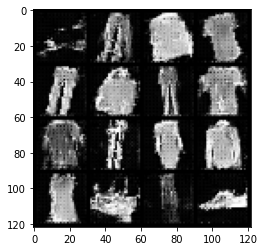

In [92]:
for i in range(epochs):
  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_img, _ in trainloader:
    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device = device)

    # Find Loss and update weights for D

    D_opt.zero_grad()

    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_real_loss + D_fake_loss)/2

    total_d_loss += D_loss.item()

    D_loss.backward()
    D_opt.step()

    # Find Loss and update weights for G

    G_opt.zero_grad()
    noise = torch.randn(batch_size, noise_dim, device = device)

    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)

    total_g_loss += G_loss.item()

    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss / len(trainloader)
  avg_g_loss = total_g_loss / len(trainloader)

  print(f"Epoch : {i+1} | D_loss : {avg_d_loss} | G_loss : {avg_g_loss}")

  show_tensor_images(fake_img)

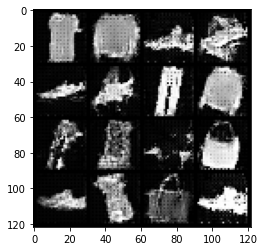

In [93]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)